In [ ]:
# 掛載 Google Drive
from google.colab import drive  # 匯入掛載 Google Drive 的模組
drive.mount('/content/drive')  # 將 Google Drive 掛載到 Colab 的 /content/drive 目錄

Mounted at /content/drive


In [ ]:
# 安裝必要套件
!pip install transformers  # 安裝 Hugging Face 的 transformers 套件
!pip install nltk         # 安裝自然語言處理套件 NLTK
!pip install matplotlib   # 安裝 Matplotlib 繪圖套件
!pip install seaborn      # 安裝 Seaborn 資料視覺化套件

In [ ]:
# 匯入函式庫
import pandas as pd  # 匯入 pandas 資料分析套件，簡稱 pd，以便進行資料讀取與操作
import numpy as np  # 匯入 NumPy 數值運算套件，簡稱 np，用於陣列及矩陣運算
import torch  # 匯入 PyTorch 深度學習框架，用於模型建立與張量運算
from torch.utils.data import DataLoader, Dataset  # 匯入 DataLoader 批次載入工具與 Dataset 資料集基底類別
from transformers import RobertaTokenizer, RobertaForSequenceClassification  # 匯入 RoBERTa 分詞器與，用於文本分類的預訓練模型
from torch.optim import AdamW  # 匯入 AdamW 最佳化器，支援權重衰減正則化
from transformers import get_scheduler  # 匯入學習率排程器生成函式，用於動態調整學習率
from sklearn.model_selection import StratifiedKFold  # 匯入分層抽樣的 K 折交叉驗證工具
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report  # 匯入多種評估指標與報表函式
from tqdm import tqdm  # 匯入進度條顯示套件，用於在迴圈中追蹤執行進度
import nltk  # 匯入自然語言處理套件 NLTK，用於文字前處理
import matplotlib.pyplot as plt  # 匯入 Matplotlib 的 pyplot，簡稱 plt，用於繪製圖表
import seaborn as sns  # 匯入 Seaborn 資料視覺化套件，用於美化圖表
from collections import defaultdict  # 匯入 defaultdict，方便建立具有預設值的字典

# 下載 NLTK 資源
nltk.download('stopwords')  # 下載停用詞列表，用於移除常見無意義詞彙
nltk.download('punkt')     # 下載句子與詞彙切分模型，用於斷詞處理
from nltk.corpus import stopwords  # 匯入停用詞語料庫，以便後續過濾文本中的停用詞

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# 設定繪圖風格
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [ ]:
# 設定設備
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# 載入資料
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/test.csv")
submission = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/sample_submission.csv")

In [ ]:
# 使用 text 欄位與 target 作為輸入與標籤
train_texts = train['text'].astype(str).tolist()
train_labels = train['target'].tolist()
test_texts = test['text'].astype(str).tolist()

In [ ]:
# 使用 RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-large')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

In [ ]:
# 定義 Dataset 類別
class TweetDataset(Dataset):
    def __init__(self, texts, labels=None, max_length=64, padding='max_length'):
        self.encodings = tokenizer(texts, truncation=True, padding=padding, max_length=max_length)
        self.labels = labels

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

In [ ]:
# 儲存每個 fold 的結果
fold_results = defaultdict(list)
fold_roc_curves = []

In [ ]:
# Cross-validation + 模型平均
# 建立分層 K 折交叉驗證，總共 5 折，並設定隨機種子以確保可重現性
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# 初始化測試集預測機率矩陣，形狀為 (測試樣本數, 類別數)
test_preds = np.zeros((len(test), 2))

# 迭代每一折的訓練與驗證
for fold, (train_idx, val_idx) in enumerate(skf.split(train_texts, train_labels)):
    # 顯示當前折數
    print(f"\n=== Fold {fold+1} ===")

    # 根據索引切分訓練集與驗證集的文字和標籤
    train_texts_fold = [train_texts[i] for i in train_idx]  # 本折訓練文字列表
    train_labels_fold = [train_labels[i] for i in train_idx]  # 本折訓練標籤列表
    val_texts_fold = [train_texts[i] for i in val_idx]      # 本折驗證文字列表
    val_labels_fold = [train_labels[i] for i in val_idx]     # 本折驗證標籤列表

    # 建立 Dataset 物件
    train_dataset = TweetDataset(train_texts_fold, train_labels_fold)  # 訓練集
    val_dataset = TweetDataset(val_texts_fold, val_labels_fold)   # 驗證集
    test_dataset = TweetDataset(test_texts)  # 測試集（無標籤）

    # 建立 DataLoader 以批次方式讀取資料
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)  # 打亂訓練集
    val_loader = DataLoader(val_dataset, batch_size=8)  # 驗證集不打亂
    test_loader = DataLoader(test_dataset, batch_size=8)  # 測試集

    # 載入預訓練 RoBERTa 分類模型並設定輸出類別數為 2
    model = RobertaForSequenceClassification.from_pretrained("roberta-large", num_labels=2)
    model.to(device)  # 將模型移到指定裝置（GPU 或 CPU）

    # 設定優化器與學習率排程器
    optimizer = AdamW(model.parameters(), lr=2e-5)  # 使用 AdamW 優化器，學習率 2e-5
    num_training_steps = len(train_loader) * 3     # 總訓練步數：批次數 × Epoch 數
    lr_scheduler = get_scheduler(
        "linear", optimizer=optimizer, num_warmup_steps=0,
        num_training_steps=num_training_steps     # 線性遞減學習率排程
    )

    # 建立用於記錄訓練與驗證歷史的清單
    train_losses = []       # 每個 Epoch 的訓練損失
    val_accuracies = []     # 每個 Epoch 的驗證準確率
    val_f1_scores = []      # 每個 Epoch 的驗證 F1 分數

    # 訓練迴圈：總共 3 個 Epoch
    for epoch in range(3):
        print(f"Epoch {epoch + 1}")
        model.train()       # 切換模型至訓練模式
        epoch_losses = []   # 暫存本 Epoch 所有批次的損失

        loop = tqdm(train_loader, leave=True)  # 包裝進度條
        for batch in loop:
            # 將輸入與標籤移到對應裝置
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)   # 前向傳播
            loss = outputs.loss     # 取得損失值
            loss.backward()   # 反向傳播
            optimizer.step()  # 更新模型參數
            lr_scheduler.step()   # 更新學習率
            optimizer.zero_grad()  # 清空梯度

            epoch_losses.append(loss.item())   # 儲存損失數值
            loop.set_postfix(loss=loss.item()) # 更新進度條顯示

        # 計算並記錄本 Epoch 的平均訓練損失
        avg_train_loss = np.mean(epoch_losses)
        train_losses.append(avg_train_loss)

        # 驗證階段
        model.eval()        # 切換模型至評估模式
        val_preds, val_probs, val_true = [], [], []  # 初始化儲存預測結果與實際標籤的清單

        with torch.no_grad():  # 停止梯度計算以加速
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)            # 前向傳播
                logits = outputs.logits             # 取得輸出分數
                probs = torch.softmax(logits, dim=1).cpu().numpy()  # 計算類別機率並移回 CPU
                preds = np.argmax(probs, axis=1)     # 取最大機率的索引作為預測

                val_preds.extend(preds)              # 累加預測標籤
                val_probs.extend(probs[:, 1])        # 累加正類機率
                val_true.extend(batch['labels'].cpu().numpy())  # 累加真實標籤

        # 計算並記錄本 Epoch 的驗證評估指標
        val_accuracy = accuracy_score(val_true, val_preds)
        val_f1 = f1_score(val_true, val_preds, average='weighted')
        val_accuracies.append(val_accuracy)
        val_f1_scores.append(val_f1)

        print(
            f"Epoch {epoch + 1} - "
            f"Train Loss: {avg_train_loss:.4f}, "
            f"Val Acc: {val_accuracy:.4f}, "
            f"Val F1: {val_f1:.4f}"
        )

    # 最終驗證評估：在驗證集上做完整一次前向傳播以獲取最終指標
    model.eval()
    final_val_preds, final_val_probs, final_val_true = [], [], []

    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            preds = np.argmax(probs, axis=1)

            final_val_preds.extend(preds)
            final_val_probs.extend(probs[:, 1])
            final_val_true.extend(batch['labels'].cpu().numpy())

    # 計算最終的 Accuracy、F1 與 ROC AUC
    final_accuracy = accuracy_score(final_val_true, final_val_preds)
    final_f1 = f1_score(final_val_true, final_val_preds, average='weighted')
    final_roc_auc = roc_auc_score(final_val_true, final_val_probs)

    # 將本折結果儲存至字典
    fold_results['accuracy'].append(final_accuracy)
    fold_results['f1'].append(final_f1)
    fold_results['roc_auc'].append(final_roc_auc)
    fold_results['train_losses'].append(train_losses)
    fold_results['val_accuracies'].append(val_accuracies)
    fold_results['val_f1_scores'].append(val_f1_scores)

    # 計算並儲存 ROC 曲線資料
    fpr, tpr, _ = roc_curve(final_val_true, final_val_probs)
    fold_roc_curves.append((fpr, tpr, final_roc_auc))

    # 計算並儲存混淆矩陣
    cm = confusion_matrix(final_val_true, final_val_preds)
    fold_results['confusion_matrices'].append(cm)

    # 顯示本折最終結果報表
    print(f"Fold {fold+1} Results:")
    print(f"Accuracy: {final_accuracy:.4f}")
    print(f"F1 Score: {final_f1:.4f}")
    print(f"ROC AUC: {final_roc_auc:.4f}")
    print(f"Classification Report:\n{classification_report(final_val_true, final_val_preds)}")

    # 使用訓練好的模型對測試集進行預測
    fold_preds = []
    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            fold_preds.append(probs)

    # 合併每批預測並累加到測試總預測矩陣（取平均）
    fold_preds = np.vstack(fold_preds)
    test_preds += fold_preds / 5  # 5 折平均

# 取得最終測試集預測標籤
final_preds = np.argmax(test_preds, axis=1)
submission['target'] = final_preds  # 填入提交檔
submission.to_csv("submission_cv_ensemble.csv", index=False)  # 儲存提交檔
print("✅ submission_cv_ensemble.csv 儲存完成")


=== Fold 1 ===


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1


100%|██████████| 762/762 [05:01<00:00,  2.53it/s, loss=0.174]


Epoch 1 - Train Loss: 0.4991, Val Acc: 0.8280, Val F1: 0.8264
Epoch 2


100%|██████████| 762/762 [05:01<00:00,  2.53it/s, loss=0.922]


Epoch 2 - Train Loss: 0.3568, Val Acc: 0.8293, Val F1: 0.8296
Epoch 3


100%|██████████| 762/762 [05:01<00:00,  2.53it/s, loss=0.0892]


Epoch 3 - Train Loss: 0.2720, Val Acc: 0.8372, Val F1: 0.8367
Fold 1 Results:
Accuracy: 0.8372
F1 Score: 0.8367
ROC AUC: 0.8937
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       868
           1       0.82      0.79      0.81       655

    accuracy                           0.84      1523
   macro avg       0.84      0.83      0.83      1523
weighted avg       0.84      0.84      0.84      1523


=== Fold 2 ===


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1


100%|██████████| 762/762 [05:01<00:00,  2.53it/s, loss=0.085]


Epoch 1 - Train Loss: 0.4818, Val Acc: 0.8299, Val F1: 0.8235
Epoch 2


100%|██████████| 762/762 [05:01<00:00,  2.53it/s, loss=0.146]


Epoch 2 - Train Loss: 0.3526, Val Acc: 0.8490, Val F1: 0.8476
Epoch 3


100%|██████████| 762/762 [05:01<00:00,  2.53it/s, loss=0.06]


Epoch 3 - Train Loss: 0.2679, Val Acc: 0.8464, Val F1: 0.8449
Fold 2 Results:
Accuracy: 0.8464
F1 Score: 0.8449
ROC AUC: 0.9055
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87       869
           1       0.86      0.77      0.81       654

    accuracy                           0.85      1523
   macro avg       0.85      0.84      0.84      1523
weighted avg       0.85      0.85      0.84      1523


=== Fold 3 ===


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1


100%|██████████| 762/762 [05:01<00:00,  2.53it/s, loss=0.838]


Epoch 1 - Train Loss: 0.4913, Val Acc: 0.8181, Val F1: 0.8130
Epoch 2


100%|██████████| 762/762 [05:01<00:00,  2.53it/s, loss=0.156]


Epoch 2 - Train Loss: 0.3845, Val Acc: 0.8221, Val F1: 0.8180
Epoch 3


100%|██████████| 762/762 [05:01<00:00,  2.53it/s, loss=0.0162]


Epoch 3 - Train Loss: 0.3007, Val Acc: 0.8306, Val F1: 0.8300
Fold 3 Results:
Accuracy: 0.8306
F1 Score: 0.8300
ROC AUC: 0.8936
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85       869
           1       0.82      0.78      0.80       654

    accuracy                           0.83      1523
   macro avg       0.83      0.82      0.83      1523
weighted avg       0.83      0.83      0.83      1523


=== Fold 4 ===


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1


100%|██████████| 762/762 [05:01<00:00,  2.53it/s, loss=0.701]


Epoch 1 - Train Loss: 0.6205, Val Acc: 0.5703, Val F1: 0.4142
Epoch 2


100%|██████████| 762/762 [05:01<00:00,  2.53it/s, loss=0.545]


Epoch 2 - Train Loss: 0.6888, Val Acc: 0.5703, Val F1: 0.4142
Epoch 3


100%|██████████| 762/762 [05:01<00:00,  2.53it/s, loss=0.558]


Epoch 3 - Train Loss: 0.6875, Val Acc: 0.5703, Val F1: 0.4142
Fold 4 Results:
Accuracy: 0.5703
F1 Score: 0.4142
ROC AUC: 0.5017
Classification Report:
              precision    recall  f1-score   support

           0       0.57      1.00      0.73       868
           1       0.00      0.00      0.00       654

    accuracy                           0.57      1522
   macro avg       0.29      0.50      0.36      1522
weighted avg       0.33      0.57      0.41      1522



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



=== Fold 5 ===


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1


100%|██████████| 762/762 [05:01<00:00,  2.53it/s, loss=0.169]


Epoch 1 - Train Loss: 0.4748, Val Acc: 0.8403, Val F1: 0.8386
Epoch 2


100%|██████████| 762/762 [05:01<00:00,  2.53it/s, loss=0.797]


Epoch 2 - Train Loss: 0.3517, Val Acc: 0.8436, Val F1: 0.8405
Epoch 3


100%|██████████| 762/762 [05:01<00:00,  2.53it/s, loss=0.704]


Epoch 3 - Train Loss: 0.2584, Val Acc: 0.8338, Val F1: 0.8334
Fold 5 Results:
Accuracy: 0.8338
F1 Score: 0.8334
ROC AUC: 0.9007
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       868
           1       0.82      0.79      0.80       654

    accuracy                           0.83      1522
   macro avg       0.83      0.83      0.83      1522
weighted avg       0.83      0.83      0.83      1522

✅ submission_cv_ensemble.csv 儲存完成


In [ ]:
# 繪製結果圖表
def plot_results():
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('5-Fold Cross-Validation Results', fontsize=16, fontweight='bold')

    # 1. 準確率分布
    axes[0, 0].boxplot(fold_results['accuracy'])
    axes[0, 0].set_title('Accuracy Distribution')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_xticklabels(['Accuracy'])
    axes[0, 0].grid(True, alpha=0.3)

    # 添加平均值和標準差
    mean_acc = np.mean(fold_results['accuracy'])
    std_acc = np.std(fold_results['accuracy'])
    axes[0, 0].text(0.5, 0.95, f'Mean: {mean_acc:.4f}\nStd: {std_acc:.4f}',
                    transform=axes[0, 0].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # 2. F1 分數分布
    axes[0, 1].boxplot(fold_results['f1'])
    axes[0, 1].set_title('F1 Score Distribution')
    axes[0, 1].set_ylabel('F1 Score')
    axes[0, 1].set_xticklabels(['F1 Score'])
    axes[0, 1].grid(True, alpha=0.3)

    mean_f1 = np.mean(fold_results['f1'])
    std_f1 = np.std(fold_results['f1'])
    axes[0, 1].text(0.5, 0.95, f'Mean: {mean_f1:.4f}\nStd: {std_f1:.4f}',
                    transform=axes[0, 1].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # 3. ROC AUC 分布
    axes[0, 2].boxplot(fold_results['roc_auc'])
    axes[0, 2].set_title('ROC AUC Distribution')
    axes[0, 2].set_ylabel('ROC AUC')
    axes[0, 2].set_xticklabels(['ROC AUC'])
    axes[0, 2].grid(True, alpha=0.3)

    mean_auc = np.mean(fold_results['roc_auc'])
    std_auc = np.std(fold_results['roc_auc'])
    axes[0, 2].text(0.5, 0.95, f'Mean: {mean_auc:.4f}\nStd: {std_auc:.4f}',
                    transform=axes[0, 2].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # 4. ROC 曲線
    colors = ['blue', 'red', 'green', 'purple', 'orange']
    for i, (fpr, tpr, auc) in enumerate(fold_roc_curves):
        axes[1, 0].plot(fpr, tpr, color=colors[i], alpha=0.7,
                       label=f'Fold {i+1} (AUC = {auc:.3f})')

    axes[1, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
    axes[1, 0].set_xlabel('False Positive Rate')
    axes[1, 0].set_ylabel('True Positive Rate')
    axes[1, 0].set_title('ROC Curves for All Folds')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # 5. 訓練損失曲線
    for i, losses in enumerate(fold_results['train_losses']):
        axes[1, 1].plot(range(1, len(losses)+1), losses,
                       color=colors[i], alpha=0.7, label=f'Fold {i+1}')

    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Training Loss')
    axes[1, 1].set_title('Training Loss Curves')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # 6. 驗證準確率曲線
    for i, acc in enumerate(fold_results['val_accuracies']):
        axes[1, 2].plot(range(1, len(acc)+1), acc,
                       color=colors[i], alpha=0.7, label=f'Fold {i+1}')

    axes[1, 2].set_xlabel('Epoch')
    axes[1, 2].set_ylabel('Validation Accuracy')
    axes[1, 2].set_title('Validation Accuracy Curves')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('cv_results.png', dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
# 繪製混淆矩陣
def plot_confusion_matrices():
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Confusion Matrices for All Folds', fontsize=16, fontweight='bold')

    for i, cm in enumerate(fold_results['confusion_matrices']):
        row = i // 3
        col = i % 3

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   ax=axes[row, col], cbar=False)
        axes[row, col].set_title(f'Fold {i+1}')
        axes[row, col].set_xlabel('Predicted')
        axes[row, col].set_ylabel('Actual')

    # 移除最後一個空的子圖
    axes[1, 2].remove()

    plt.tight_layout()
    plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
    plt.show()


繪製評估結果圖表...


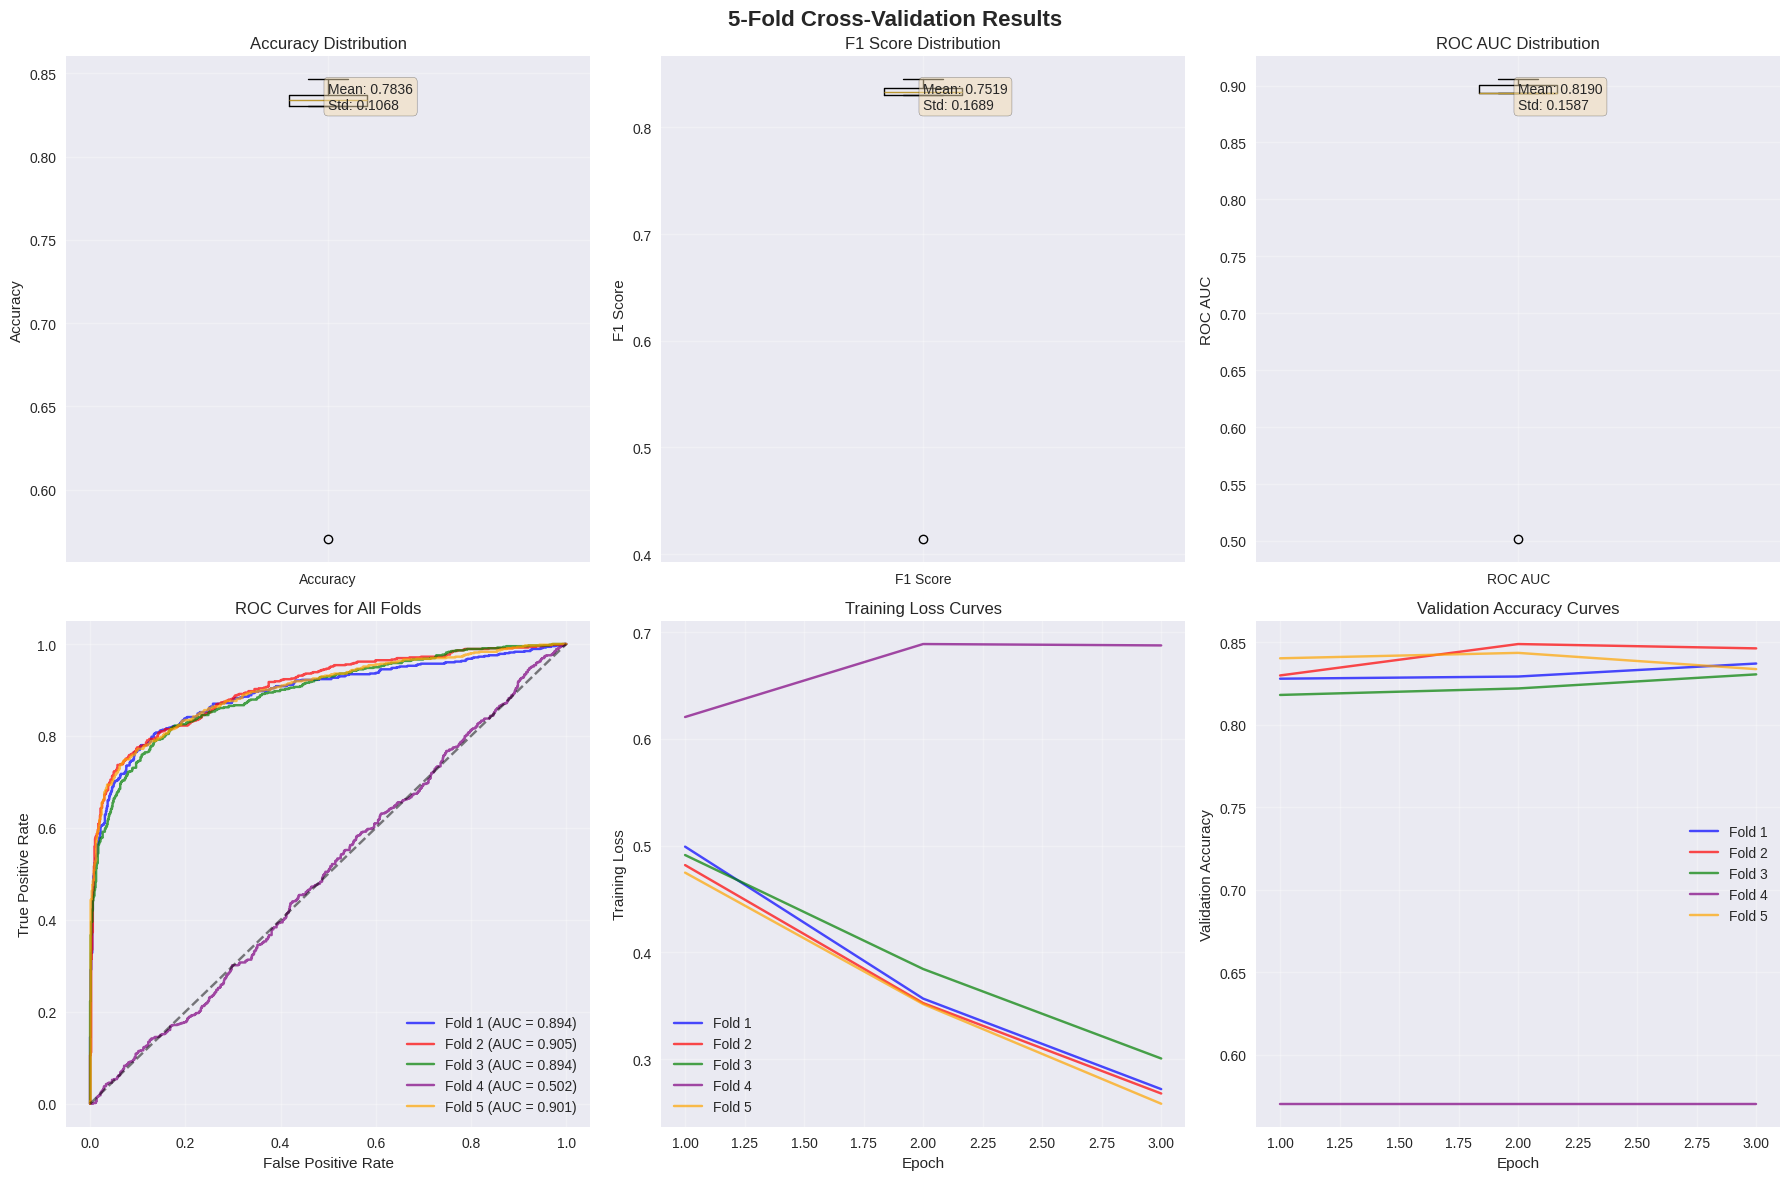

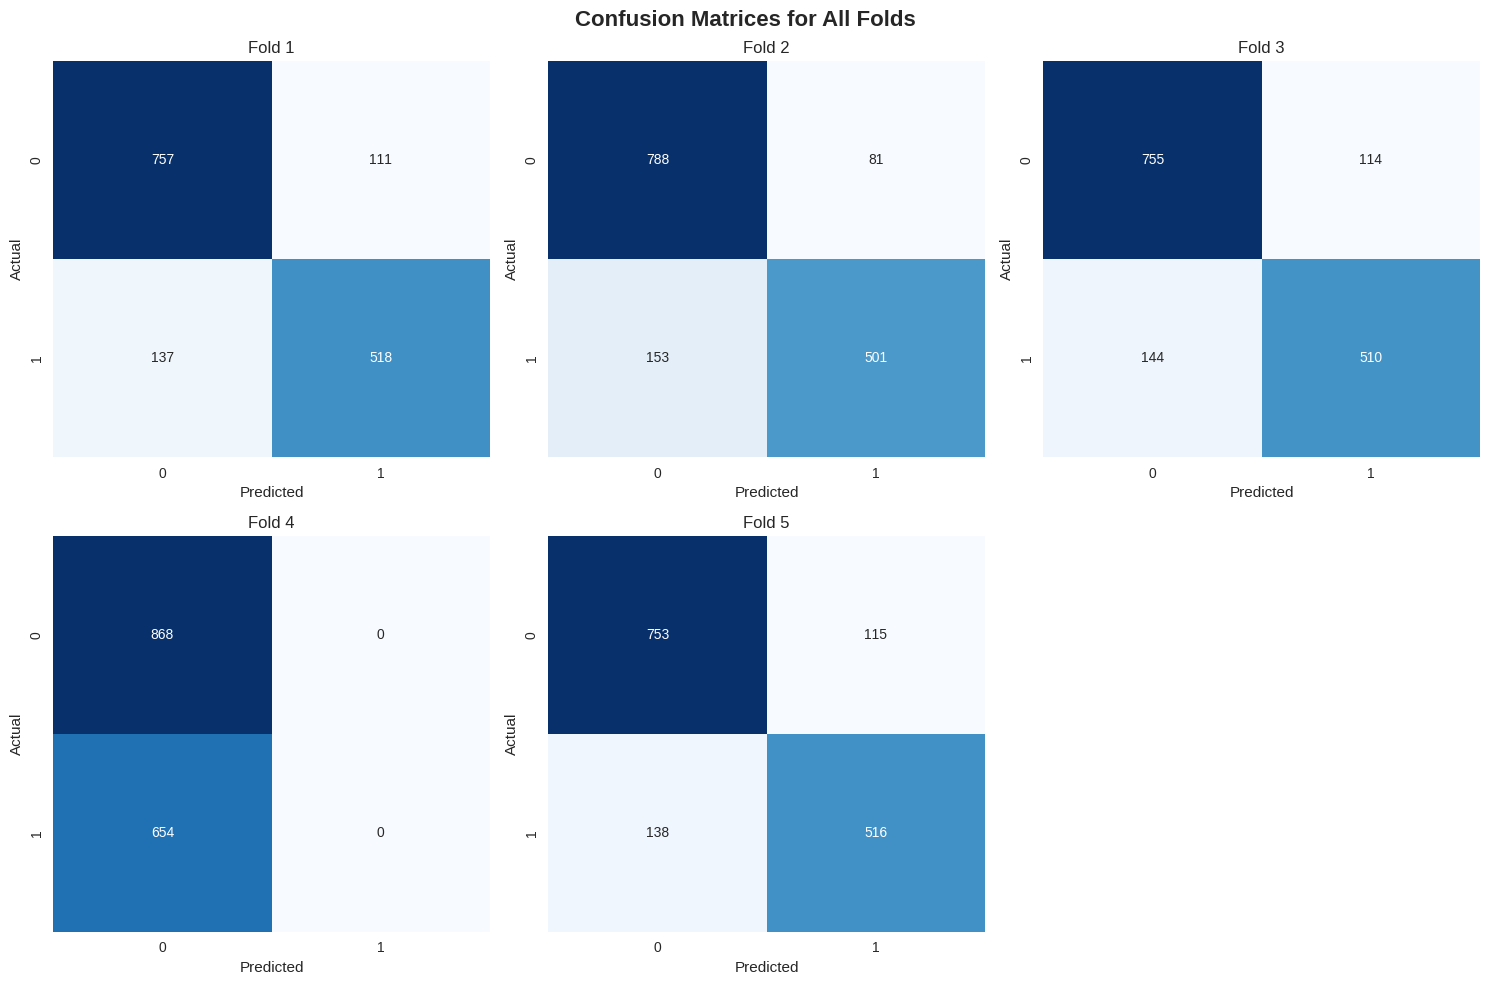

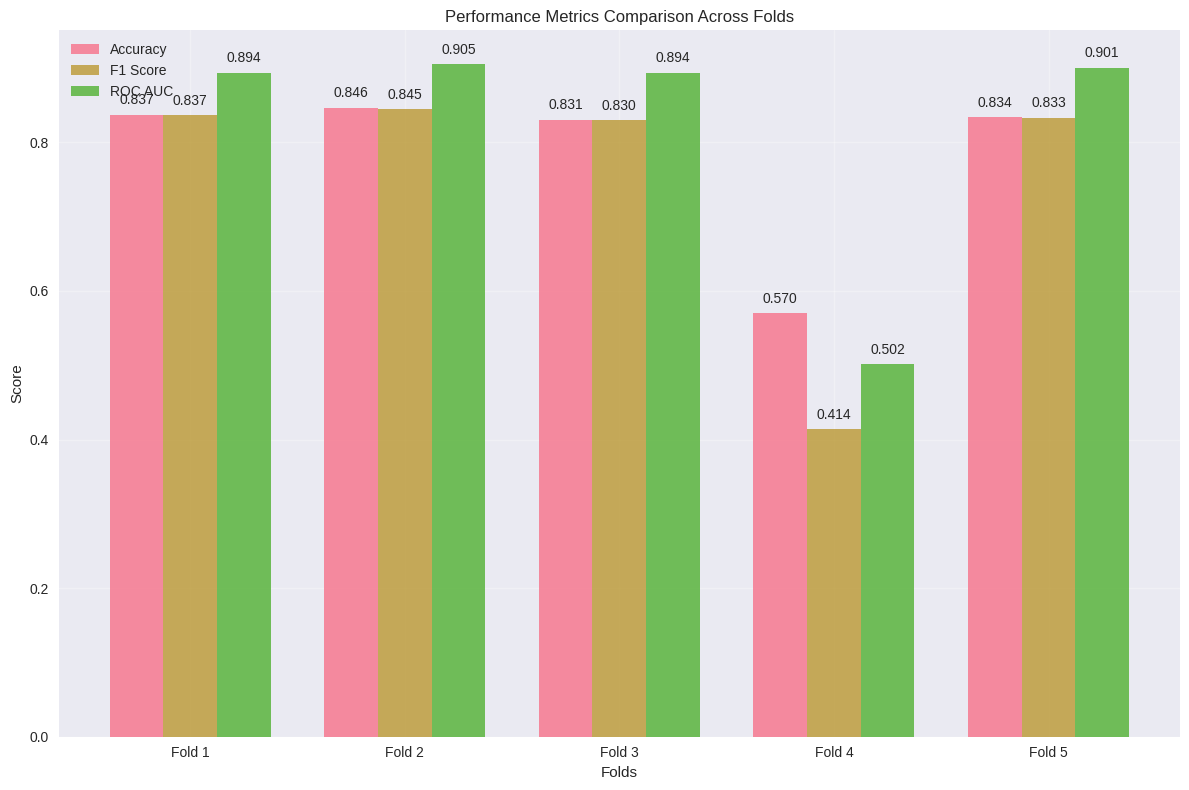


最終交叉驗證結果統計
平均準確率: 0.7836 ± 0.1068
平均 F1 分數: 0.7519 ± 0.1689
平均 ROC AUC: 0.8190 ± 0.1587


In [ ]:
# 繪製指標比較圖
def plot_metrics_comparison():
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    folds = [f'Fold {i+1}' for i in range(5)]
    x = np.arange(len(folds))
    width = 0.25

    ax.bar(x - width, fold_results['accuracy'], width, label='Accuracy', alpha=0.8)
    ax.bar(x, fold_results['f1'], width, label='F1 Score', alpha=0.8)
    ax.bar(x + width, fold_results['roc_auc'], width, label='ROC AUC', alpha=0.8)

    ax.set_xlabel('Folds')
    ax.set_ylabel('Score')
    ax.set_title('Performance Metrics Comparison Across Folds')
    ax.set_xticks(x)
    ax.set_xticklabels(folds)
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 添加數值標籤
    for i, fold in enumerate(folds):
        ax.text(i - width, fold_results['accuracy'][i] + 0.01,
               f'{fold_results["accuracy"][i]:.3f}', ha='center', va='bottom')
        ax.text(i, fold_results['f1'][i] + 0.01,
               f'{fold_results["f1"][i]:.3f}', ha='center', va='bottom')
        ax.text(i + width, fold_results['roc_auc'][i] + 0.01,
               f'{fold_results["roc_auc"][i]:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig('metrics_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# 繪製所有圖表
print("\n" + "="*50)
print("繪製評估結果圖表...")
print("="*50)

plot_results()
plot_confusion_matrices()
plot_metrics_comparison()

# 輸出最終統計結果
print("\n" + "="*50)
print("最終交叉驗證結果統計")
print("="*50)
print(f"平均準確率: {np.mean(fold_results['accuracy']):.4f} ± {np.std(fold_results['accuracy']):.4f}")
print(f"平均 F1 分數: {np.mean(fold_results['f1']):.4f} ± {np.std(fold_results['f1']):.4f}")
print(f"平均 ROC AUC: {np.mean(fold_results['roc_auc']):.4f} ± {np.std(fold_results['roc_auc']):.4f}")
print("="*50)